In [1]:
#Updating previous MATLAB script to work in Python
#Given meiyu_clean.nc and meiyu_2_clean.nc, finds mean rainband frequency and intensity for different time periods
#and also their product f*q as a proxy for actual rainfall amounts.
#Idea is to help show a causality of rainfall amounts (frequency change, or intensity?)

#meiyu_clean.nc contains every rainband event categorized as primary, and meiyu_2_clean includes all secondary events.

import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#Access NetCDF files (currently hosted in Ferret directory)
RDA_path_1 = "/Users/Siwen/Desktop/ferret/bin/meiyu_clean.nc"
RDA_path_2 = "/Users/Siwen/Desktop/ferret/bin/meiyu_2_clean.nc"
RDA_1 = nc.Dataset(RDA_path_1, 'r')
RDA_2 = nc.Dataset(RDA_path_2, 'r')

In [3]:
#load data from NetCDF files to notebook
lat_1_all =  RDA_1.variables['lat_115'][:]
lat_2_all =  RDA_2.variables['lat_115'][:]
intensity_1_all = RDA_1.variables['intensity'][:] 
intensity_2_all = RDA_2.variables['intensity'][:]

In [4]:
#Assign a calendar date to each time point
startday = datetime.datetime(1951,1,1)
date_list = np.array([datetime.timedelta(days=x) + startday for x in range(0, 20819)])

In [5]:
#Define empty variables reshaped with axis 0 as day of year and axis 1 as year.
lat_1 = np.zeros([365,57])
lat_2 = np.zeros([365,57])
intensity_1 = np.zeros([365,57])
intensity_2 = np.zeros([365,57])

In [6]:
#interestinng unexpected behavior - list(mymap) turns mymap into actual array, but:
#needs to then be converted into np.array, otherwise it chooses either the first or second
#array element based on whether true or false (as opposed to including an element if
#corresponding bool array element is true)!

for i, date in enumerate(date_list[0:365]):
    
    dd = date.day
    mm = date.month
    mymap = map(lambda date: (date.day == dd) & (date.month == mm), date_list)
    extract = np.array(list(mymap))
    
    lat_1[i,:] = lat_1_all[extract]
    lat_2[i,:] = lat_2_all[extract]
    intensity_1[i,:] = intensity_1_all[extract]
    intensity_2[i,:] = intensity_2_all[extract]

In [7]:
#convert latitude information into binning by latitude
#BINS: <20, 20-40 by 1 degree bin, and 40+
lat_1_index = np.round(lat_1-19.5)
lat_1_index[lat_1_index < 0] = 0
lat_1_index[lat_1_index > 21] = 21

lat_2_index = np.round(lat_2-19.5)
lat_2_index[lat_2_index < 0] = 0
lat_2_index[lat_2_index > 21] = 21

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


In [8]:
#convert indices into Hovmoller plot
lat_1_hov = np.zeros([365,22])
lat_2_hov = np.zeros([365,22])

#below, we divide by 57 (the number of years in our data set) to switch units from raw counts to frequency.

#for primary fronts:
for dd, col in enumerate(lat_1_index):
    for ix in range(22):
        lat_1_hov[dd,ix] = np.count_nonzero(col == ix)/57
        
#for secondary fronts:
for dd, col in enumerate(lat_2_index):
    for ix in range(22):
        lat_2_hov[dd,ix] = np.count_nonzero(col == ix)/57

In [9]:
#combine into single variable
lat_hov = lat_1_hov + lat_2_hov

<IPython.core.display.Javascript object>


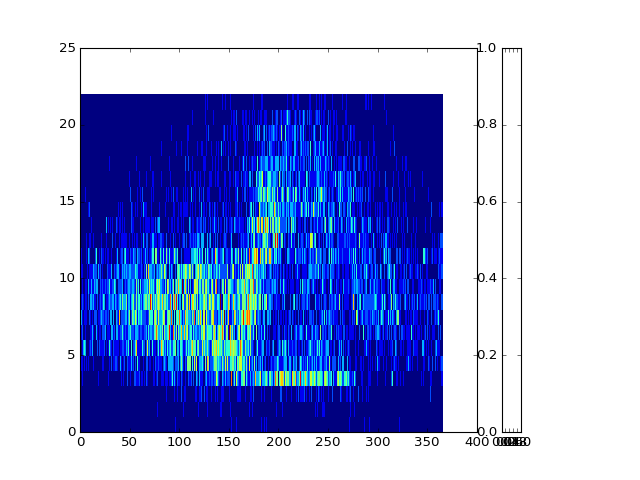

AttributeError: 'AxesSubplot' object has no attribute 'autoscale_None'

In [18]:
fig1, ax1=plt.subplots()
ax1.pcolormesh(lat_hov.T)

In [15]:
#handy smoothing function which allows for different smoothing in time direction and latitude direction, and also
#wraps time axis
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

In [24]:
#smoothed occupancy plots for frontal events
lat_1_hov_smth = smooth(lat_1_hov,15,5)
lat_2_hov_smth = smooth(lat_2_hov,15,5)
lat_hov_smth = smooth(lat_hov,15,5)

In [40]:
#SAVE AS NETCDF FILE
savefile = "RDA_hov.nc"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(hovname):
    os.remove(hovname)

hovout = nc.Dataset(hovname, "w")

#create dimensions
days_dim = hovout.createDimension('time', None)
lat_dim = hovout.createDimension('lat', 22)

dim_tuple = ("time","lat")

#create variables inside netCDF file
lat_1_out = hovout.createVariable("lat_1_hov", 'f8', dim_tuple)
lat_2_out = hovout.createVariable("lat_2_hov", 'f8', dim_tuple)
lat_out = hovout.createVariable("lat_hov", 'f8', dim_tuple)

lat_1_smth_out = hovout.createVariable("lat_1_hov_smth", 'f8', dim_tuple)
lat_2_smth_out = hovout.createVariable("lat_2_hov_smth", 'f8', dim_tuple)
lat_smth_out = hovout.createVariable("lat_hov_smth", 'f8', dim_tuple)

lat_1_out[:] = lat_1_hov
lat_2_out[:] = lat_2_hov
lat_out[:] = lat_hov

lat_1_smth_out[:] = lat_1_hov_smth
lat_2_smth_out[:] = lat_2_hov_smth
lat_smth_out[:] = lat_hov_smth

hovout.close()

<IPython.core.display.Javascript object>


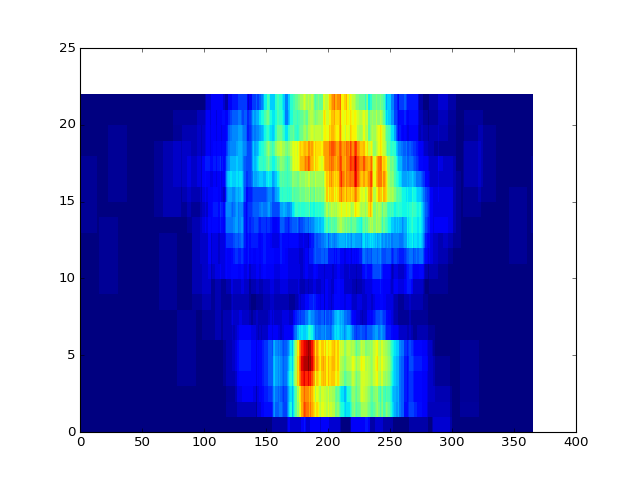

In [30]:
fig2, ax2=plt.subplots()
ax2.pcolormesh(lat_2_hov_smth.T)

In [84]:
date_list = np.array([datetime.timedelta(days=x) + startday for x in range(0, 20819)])

In [144]:
mymap = map(lambda date: (date.day == 3) & (date.month == 1), date_list)
test1 = list(mymap)
test2 = np.array(test1)
test3 = np.array(list(mymap))
test4 = np.array(mymap)

In [145]:
print(test1[:10])
print(test2[:10])
print(test3[:10])
print(test4[:10])

[False, False, True, False, False, False, False, False, False, False]
[False False  True False False False False False False False]
[]


IndexError: too many indices for array

In [149]:
print(mymap)

In [143]:
type(test2)

numpy.ndarray

In [139]:
print(date_list[test1][:10])


[datetime.datetime(1951, 1, 1, 0, 0) datetime.datetime(1951, 1, 1, 0, 0)
 datetime.datetime(1951, 1, 2, 0, 0) datetime.datetime(1951, 1, 1, 0, 0)
 datetime.datetime(1951, 1, 1, 0, 0) datetime.datetime(1951, 1, 1, 0, 0)
 datetime.datetime(1951, 1, 1, 0, 0) datetime.datetime(1951, 1, 1, 0, 0)
 datetime.datetime(1951, 1, 1, 0, 0) datetime.datetime(1951, 1, 1, 0, 0)]


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


In [140]:
print(date_list[test2][:10])


[datetime.datetime(1951, 1, 3, 0, 0) datetime.datetime(1952, 1, 3, 0, 0)
 datetime.datetime(1953, 1, 3, 0, 0) datetime.datetime(1954, 1, 3, 0, 0)
 datetime.datetime(1955, 1, 3, 0, 0) datetime.datetime(1956, 1, 3, 0, 0)
 datetime.datetime(1957, 1, 3, 0, 0) datetime.datetime(1958, 1, 3, 0, 0)
 datetime.datetime(1959, 1, 3, 0, 0) datetime.datetime(1960, 1, 3, 0, 0)]


In [141]:
print(date_list[test3][:10])

IndexError: arrays used as indices must be of integer (or boolean) type

In [65]:
date_list[test2][:5]

IndexError: arrays used as indices must be of integer (or boolean) type